# Specific arrhythmia tests

In [3]:
import invalid_sample_detection    as invalid
import load_annotations            as annotate
import regular_activity            as regular
import numpy                       as np
import matplotlib.pyplot           as plt
import scipy
import parameters
import wfdb
from datetime import datetime

data_path = 'sample_data/challenge_training_data/'
ann_path = 'sample_data/challenge_training_multiann/'
ecg_ann_type = 'gqrs'

## Asystole

In [8]:
def calc_summed_asystole_score(ann_path, sample_name, subsig, channels, ecg_ann_type, current_start, current_end): 
    summed_score = 0
    
    for channel_index, channel in zip(range(len(channels)), channels): 
        channel_type = invalid.get_channel_type(channel)
        if channel_type == "Resp": 
            continue
        
        invalids = invalid.calculate_channel_invalids(subsig[:,channel_index], channel_type)
        cval = invalid.calculate_cval_channel(invalids)
        
        ann_type = annotate.get_ann_type(channel, channel_index, ecg_ann_type)
        ann_fs = annotate.get_ann_fs(channel_type)
        annotation = annotate.get_annotation(ann_path + sample_name, ann_type, ann_fs, current_start, current_end)
        
        if len(annotation) == 0: 
            continue
        elif len(annotation[0]) > 0: 
            current_score = -cval
        else: 
            current_score = cval        
        
        summed_score += current_score        
        
    return summed_score   

[Errno 2] No such file or directory: 'sample_data/challenge_training_multiann/a670s.gqrs'


/home/liandrea/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


IndexError: list index out of range

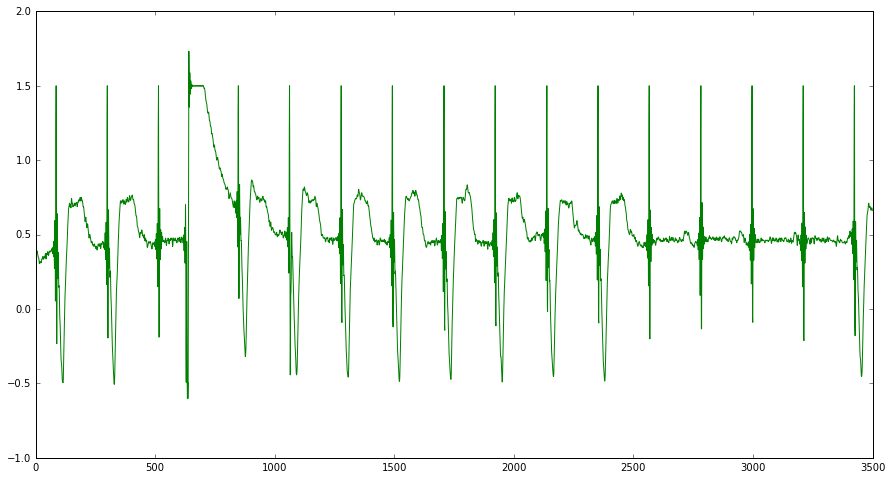

In [13]:
def test_asystole(data_path, ann_path, sample_name, ecg_ann_type): 
    sig, fields = wfdb.rdsamp(data_path + sample_name)
    channels = fields['signame']
    fs = fields['fs']
        
    # Start and end given in seconds
    start, end, alarm_duration = invalid.get_start_and_end(fields)
    current_start = start
    current_end = current_start + parameters.ASYSTOLE_WINDOW_SIZE
    
    annotation = annotate.get_annotation(ann_path + sample_name, ecg_ann_type, 125, start*fs, end*fs)
    plt.figure(figsize=[15,8])
    plt.plot(sig[start*fs:end*fs,0], 'g-')
    plt.plot(annotation[0], 'bo', markersize=8)
    plt.show()
    
    max_score = 0
    
    while current_end < end: 
        subsig = sig[current_start*fs:current_end*fs,:]
        summed_asystole_score = calc_summed_asystole_score(ann_path, sample_name, subsig, channels, ecg_ann_type,
                                                           current_start, current_end)
        max_score = max(max_score, summed_asystole_score)
        
        current_start += parameters.ASYSTOLE_ROLLING_INCREMENT
        current_end = current_start + parameters.ASYSTOLE_WINDOW_SIZE
        
    return max_score > 0
    
# sample_name = "a653l"
sample_name = "a670s" # "a203l" # true alarm
# # sample_name = "a152s" # false alarm
print test_asystole(data_path, ann_path, sample_name, ecg_ann_type)

## Bradycardia

In [4]:
def get_rr_intervals_list(ann_path, sample_name, ecg_ann_type, fields, start, end): 
    channels = fields['signame']
    rr_intervals_list = []
    
    for channel_index in range(len(channels)): 
        channel_name = channels[channel_index]
        channel_type = invalid.get_channel_type(channel_name)
        if channel_type == "Resp": 
            continue
            
        rr_intervals = annotate.get_channel_rr_intervals(ann_path, sample_name, channel_index, fields,
                                                         ecg_ann_type, start, end)
        rr_intervals_list.append(rr_intervals)
        
    return rr_intervals_list


# Precondition: len(rr_intervals_list) > 0
# Return RR intervals with the min stdev of all the RR intervals in the list
def min_stdev_rr_intervals(rr_intervals_list): 
    opt_rr_intervals = []
    min_stdev = float('inf')
    
    for rr_intervals in rr_intervals_list: 
        stdev = np.std(rr_intervals)        
        if stdev < min_stdev: 
            opt_rr_intervals = rr_intervals
            min_stdev = stdev
    
    return opt_rr_intervals

In [5]:
# Best channel: minimum stdev with acceptable RR intervals sum and count
# If none with acceptable RR interval sum and count --> select minimum stdev out of all RR intervals
def find_best_channel(rr_intervals_list, alarm_duration): 
    count_and_sum = []
    only_one_test = []
    for rr_intervals in rr_intervals_list: 
        sum_check = regular.check_sum_rr_intervals(rr_intervals, alarm_duration)
        num_check = regular.check_num_rr_intervals(rr_intervals)
        
        if sum_check and num_check: 
            count_and_sum.append(rr_intervals)
        
        elif sum_check or num_check: 
            only_one_test.append(rr_intervals)
    
    if len(count_and_sum) > 0: 
        return min_stdev_rr_intervals(count_and_sum)
    
    if len(only_one_test) > 0: 
        return min_stdev_rr_intervals(only_one_test)
    
    return min_stdev_rr_intervals(rr_intervals_list)            

In [6]:
def get_min_hr(rr_intervals, num_beats_per_block): 
    min_hr = float('inf')
    
    for index in range(num_beats_per_block, len(rr_intervals)): 
        subsection = rr_intervals[index - num_beats_per_block:index]
        hr = float(num_beats_per_block) / sum(subsection) * parameters.NUM_SECS_IN_MIN
        min_hr = min(min_hr, hr)
        
    return min_hr

In [7]:
def test_bradycardia(data_path, ann_path, sample_name, ecg_ann_type): 
    sig, fields = wfdb.rdsamp(data_path + sample_name)
    channels = fields['signame']

    # Start and end given in seconds
    start, end, alarm_duration = invalid.get_start_and_end(fields)
    
    rr_intervals_list = get_rr_intervals_list(ann_path, sample_name, ecg_ann_type, fields, start, end)    
    best_channel_rr = find_best_channel(rr_intervals_list, alarm_duration)
    min_hr = get_min_hr(best_channel_rr, parameters.BRADYCARDIA_NUM_BEATS)
    return min_hr < parameters.BRADYCARDIA_HR_MIN

# sample_name = "b183l" # true alarm
# # sample_name = "b216s" #"b184s" # false alarm
# print test_bradycardia(data_path, ann_path, sample_name, ecg_ann_type)

## Tachycardia

In [8]:
def check_tachycardia_channel(rr_intervals_list, alarm_duration): 
    for rr_intervals in rr_intervals_list: 
        stdev_check = regular.check_rr_stdev(rr_intervals)
        sum_check = regular.check_sum_rr_intervals(rr_intervals, alarm_duration)
        hr_check = regular.check_heart_rate(rr_intervals, alarm_duration)
        if stdev_check and sum_check and not hr_check:
            return True
            
    return False

In [9]:
def get_max_hr(rr_intervals, num_beats_per_block): 
    max_hr = -float('inf')
    
    for index in range(num_beats_per_block, len(rr_intervals)): 
        subsection = rr_intervals[index - num_beats_per_block:index]
        hr = float(num_beats_per_block) / sum(subsection) * parameters.NUM_SECS_IN_MIN
        max_hr = max(max_hr, hr)
        
    return max_hr

In [10]:
def test_tachycardia(data_path, ann_path, sample_name, ecg_ann_type): 
    sig, fields = wfdb.rdsamp(data_path + sample_name)
    channels = fields['signame']
        
    # Start and end given in s#econds
    start, end, alarm_duration = invalid.get_start_and_end(fields)
    
    rr_intervals_list = get_rr_intervals_list(ann_path, sample_name, ecg_ann_type, fields, start, end)    
    if check_tachycardia_channel(rr_intervals_list, alarm_duration): 
        return True    
    
    best_channel_rr = find_best_channel(rr_intervals_list, alarm_duration)
        
    max_hr = get_max_hr(best_channel_rr, parameters.TACHYCARDIA_NUM_BEATS)
    return max_hr > parameters.TACHYCARDIA_HR_MAX


# sample_name = "t209l" # true alarm
# sample_name = "t384s" # false alarm
# print test_tachycardia(data_path, ann_path, sample_name, ecg_ann_type)

## Ventricular tachycardia

In [54]:
plt.figure(figsize=[15,8])
#     plt.plot(channel_sig, 'g-')
#     plt.plot(sub,'b-')
#     plt.plot(lf,'r-')
    
#     plt.plot(nonventricular_beat_indices, [sub[index] for index in nonventricular_beat_indices], 'bo', markersize=8)
#     plt.plot(ventricular_beat_indices, [ lf[index] for index in ventricular_beat_indices ], 'ro', markersize=8)
#     plt.show()def hilbert_transform(x, fs, f_low, f_high, demod=False):
    N = len(x)
    f = scipy.fftpack.fft(x, n=N)
    i_high = int(np.floor(float(f_high)/fs*N))
    i_low = int(np.floor(float(f_low)/fs*N))
    win = scipy.signal.hamming( i_high - i_low )
    
    f[0:i_low] = 0
    f[i_low:i_high] = f[i_low:i_high]*win
    f[i_high+1:] = 0
    
    if demod==True:
        # demodulate the signal, i.e. shift the freq spectrum to 0
        i_mid = int( np.floor((i_high+i_low)/2.0) )
        f = np.concatenate( [f[i_mid:i_high], np.zeros(len(f)-(i_high-i_low)), f[i_low:i_mid] ]  )
        
    return 2*np.abs(scipy.fftpack.ifft(f, n=N))

In [11]:
# Returns index of peak (max value) in the signal out of the indices provided
def get_peak_index(signal, peak_indices): 
    max_peak_value = 0
    max_peak_index = 0
    
    for index in peak_indices: 
        if signal[index] > max_peak_value: 
            max_peak_value = signal[index]
            max_peak_index = index
    
    return max_peak_index

# Groups together indices for a single peak and outputs a list of peaks (one sample per peak)
# param index_threshold: minimum difference in sample number to be classified as a different peak
def get_single_peak_indices(signal, peak_indices, index_threshold=50): 
    single_peak_indices = np.array([])
    current_peak_indices = []
    prev_index = peak_indices[0]
    
    for index in peak_indices[1:]: 
        if abs(prev_index - index) > index_threshold: 
            peak_index = get_peak_index(signal, current_peak_indices)
            single_peak_indices = np.append(single_peak_indices, peak_index)
            current_peak_indices = [index]
        else: 
            current_peak_indices.append(index)
        
        prev_index = index

    # Handle the last peak
    peak_index = get_peak_index(signal, current_peak_indices)
    single_peak_indices = np.append(single_peak_indices, peak_index)
    
    return single_peak_indices

In [87]:
def get_lf_sub(channel_sig, order): 
    lf = abs(hilbert_transform(channel_sig, parameters.DEFAULT_ECG_FS, parameters.LF_LOW, parameters.LF_HIGH))
    mf = abs(hilbert_transform(channel_sig, parameters.DEFAULT_ECG_FS, parameters.MF_LOW, parameters.MF_HIGH))
    hf = abs(hilbert_transform(channel_sig, parameters.DEFAULT_ECG_FS, parameters.HF_LOW, parameters.HF_HIGH))
    sub = mf - hf
    
    return lf, sub

def ventricular_beat_annotations(channel_sig, sample, ann_type, start, end, channel_type,
                                 order=parameters.ORDER, 
                                 threshold_ratio=parameters.VENTRICULAR_BEAT_THRESHOLD_RATIO,
                                 ventricular_beat_percentile=parameters.VENTRICULAR_BEAT_PERCENTILE):
    lf, sub = get_lf_sub(channel_sig, order)
    
    ann_fs = annotate.get_ann_fs(channel_type)
    annotation = annotate.get_annotation(sample, ann_type, ann_fs, start, end)
    if len(annotation) == 0: 
        return []
    
    single_peak_indices = [ index - ann_fs * start for index in annotation[0] ]
    
    ventricular_beat_indices = np.array([])
    nonventricular_beat_indices = np.array([])
    
    for index in single_peak_indices:
        if index >= len(lf) or index >= len(sub): 
            print "Out of range peak"
            continue
            
        if lf[index] > sub[index]: 
            ventricular_beat_indices = np.append(ventricular_beat_indices, index)
        else: 
            nonventricular_beat_indices = np.append(nonventricular_beat_indices, index)

#     plt.figure(figsize=[15,8])
#     plt.plot(channel_sig, 'g-')
#     plt.plot(sub,'b-')
#     plt.plot(lf,'r-')
    
#     plt.plot(nonventricular_beat_indices, [sub[index] for index in nonventricular_beat_indices], 'bo', markersize=8)
#     plt.plot(ventricular_beat_indices, [ lf[index] for index in ventricular_beat_indices ], 'ro', markersize=8)
#     plt.show()
    
    return ventricular_beat_indices

start_time = 290
end_time = 300
start = start_time * parameters.DEFAULT_ECG_FS
end = end_time * parameters.DEFAULT_ECG_FS
sample_name = "v729l"
sig, fields = wfdb.rdsamp(data_path + sample_name)
channel = "V"
channel_index = 1
ann_type = annotate.get_ann_type(channel, channel_index, ecg_ann_type)
print ventricular_beat_annotations(sig[start:end,channel_index], ann_path + sample_name, ann_type, start_time, end_time, "ECG")

[   96.   316.   525.   730.   932.  1130.  1328.  1531.  1584.  1665.
  1749.  2013.  2246.  2462.]


/home/liandrea/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:55: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/liandrea/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:30: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [70]:
def max_ventricular_hr(ventricular_beats, num_beats, fs):     
    max_hr = 0
    
    if len(ventricular_beats) < num_beats: 
        return max_hr
    
    for index in range(num_beats-1, len(ventricular_beats)): 
        sublist = ventricular_beats[index-num_beats+1:index]
        start_time = ventricular_beats[index-num_beats+1] / fs
        end_time = ventricular_beats[index] / fs
                
        hr = (num_beats-1) / (end_time - start_time) * parameters.NUM_SECS_IN_MIN         
        max_hr = max(hr, max_hr)    
        
    return max_hr

In [83]:
def calc_summed_vtach_score(subsig, channels, num_beats, fs, sample, start, end, ecg_ann_type): 
    summed_score = 0
    
    for channel_index, channel in zip(range(len(channels)), channels): 
        channel_subsig = subsig[:,channel_index]
        channel_type = invalid.get_channel_type(channel)
        ann_type = annotate.get_ann_type(channel, channel_index, ecg_ann_type)
        if channel_type == "Resp": 
            continue
        
        invalids = invalid.calculate_channel_invalids(channel_subsig, channel_type)
        cval = invalid.calculate_cval_channel(invalids)
        current_score = 0
        
        if channel_type == "ECG":
            ventricular_beats = ventricular_beat_annotations(channel_subsig, sample, ann_type, start, end, channel_type)
            max_hr = max_ventricular_hr(ventricular_beats, num_beats, fs)
            
            if max_hr > parameters.VTACH_MAX_HR: 
                current_score = cval
            else: 
                current_score = -cval
                
        elif channel_type == "BP": 
            std = np.std(channel_subsig)
            if std < parameters.VTACH_ABP_THRESHOLD: 
                current_score = cval
            else:
                current_score = -cval
                            
        summed_score += current_score        
        
    return summed_score   

In [84]:
def test_ventricular_tachycardia(data_path, 
                                 ann_path, 
                                 sample_name, 
                                 ecg_ann_type, 
                                 fs=parameters.DEFAULT_ECG_FS,
                                 num_beats=parameters.VTACH_NUM_BEATS): 
    sig, fields = wfdb.rdsamp(data_path + sample_name)
    channels = fields['signame']
        
    # Start and end given in seconds
    start, end, alarm_duration = invalid.get_start_and_end(fields)    
    current_start = start
    current_end = current_start + parameters.VTACH_WINDOW_SIZE
        
    max_score = 0
    while current_end < end: 
        subsig = sig[current_start*fs:current_end*fs,:]
        summed_vtach_score = calc_summed_vtach_score(subsig, channels, num_beats, fs, ann_path + sample_name,
                                                     current_start, current_end, ecg_ann_type)
        max_score = max(max_score, summed_vtach_score)
        
        current_start += parameters.VTACH_ROLLING_INCREMENT
        current_end = current_start + parameters.VTACH_WINDOW_SIZE
                
        if max_score > 0: 
            return True
        
    return False

# s = datetime.now()
# print test_ventricular_tachycardia(data_path, ann_path, "v818s", ecg_ann_type)
# print datetime.now() - s

/home/liandrea/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/liandrea/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:30: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


False
0:00:07.633227


## Ventricular flutter/fibrillation

In [16]:
def calculate_dlfmax(channel_sig, 
                     order=parameters.ORDER): 
    lf, sub = get_lf_sub(channel_sig, order)
    
    current_dlfmax_start = None
    dlfmax_duration = 0
    prev_low_dominance = 0
    
    for index in range(len(lf)): 
        lf_sample = lf[index]
        sub_sample = sub[index]
        
        if lf_sample > sub_sample: 
            # If not yet started a low dominance area, set the start index
            if current_dlfmax_start is None: 
                current_dlfmax_start = index
            
            # If a separate low dominance area, reset
            elif index - prev_low_dominance > parameters.VFIB_LOW_DOMINANCE_INDEX_THRESHOLD: 
                # Calculate duration of previous low dominance area and update max dlfmax
                duration = prev_low_dominance - current_dlfmax_start
                dlfmax_duration = max(dlfmax_duration, duration)
                
                # Start new area of low dominance
                current_dlfmax_start = index
            
            # Update previous index seen with low frequency dominance
            prev_low_dominance = index
            
    return dlfmax_duration
            
            
def get_abp_std_scores(channel_sig, 
                       alarm_duration, 
                       fs=parameters.DEFAULT_FS,
                       abp_threshold=parameters.VFIB_ABP_THRESHOLD,
                       window_size=parameters.VFIB_WINDOW_SIZE,
                       rolling_increment=parameters.VFIB_ROLLING_INCREMENT):
    r_delta = np.array([])
    start = 0
    
    while start < channel_sig.size: 
        end = start + window_size * fs
        channel_subsig = channel_sig[start:end]
        start += (rolling_increment * fs)

        invalids = invalid.calculate_channel_invalids(channel_subsig, "BP")
        cval = invalid.calculate_cval_channel(invalids)
        
        std = np.std(channel_subsig)        
        if std > abp_threshold: 
            r_delta = np.append(r_delta, -cval)
        else: 
            r_delta = np.append(r_delta, cval)
            
    return r_delta

# Get dominant freq in signal in rolling window
def get_dominant_freq_array(channel_sig, 
                            fs=parameters.DEFAULT_ECG_FS,
                            window_size=parameters.VFIB_WINDOW_SIZE,
                            rolling_increment=parameters.VFIB_ROLLING_INCREMENT): 
    
    start = 0
    dominant_freqs = np.array([])
    
    while start < channel_sig.size: 
        end = start + window_size * fs
        channel_subsig = channel_sig[start:end]
        start += (rolling_increment * fs)
        
        xf, fft = invalid.get_signal_fft(channel_subsig, window_size, fs)
        
        # Index of the fft is 2 * the actual frequency 
        dominant_freq = np.argmax(fft) / 2
        
        dominant_freqs = np.append(dominant_freqs, dominant_freq)
    return dominant_freqs


def get_regular_activity_array(sig,
                               fields,
                               ann_path, 
                               sample_name,
                               ecg_ann_type,
                               fs=parameters.DEFAULT_ECG_FS,
                               window_size=parameters.VFIB_WINDOW_SIZE,
                               rolling_increment=parameters.VFIB_ROLLING_INCREMENT): 
    regular_activity_array = np.array([])
    start = 0
    
    while start < sig[:,0].size: 
        end = start + window_size * fs
        start_time = start / float(fs)
        end_time = end / float(fs)
        subsig = sig[start:end]
        
        invalids_dict = invalid.calculate_invalids_sig(subsig, fields)
        rr_dict = annotate.get_rr_dict(ann_path, sample_name, fields, ecg_ann_type, start_time, end_time)
                
        is_regular = regular.is_rr_invalids_regular(rr_dict, invalids_dict, window_size, True, True, False)
        if is_regular: 
            regular_activity_array = np.append(regular_activity_array, 1)
        else: 
            regular_activity_array = np.append(regular_activity_array, 0)
            
        start += (rolling_increment * fs)
    
    return regular_activity_array


def adjust_dominant_freqs(dominant_freqs, regular_activity): 
    adjusted_dominant_freqs = np.array([])
    
    for freq, is_regular in zip(dominant_freqs, regular_activity): 
        if is_regular: 
            adjusted_dominant_freqs = np.append(adjusted_dominant_freqs, 0)
        else: 
            adjusted_dominant_freqs = np.append(adjusted_dominant_freqs, freq)
    
    return adjusted_dominant_freqs

In [17]:
def test_ventricular_flutter_fibrillation(data_path, 
                                          ann_path, 
                                          sample_name, 
                                          ecg_ann_type,
                                          fs=parameters.DEFAULT_ECG_FS,
                                          ann_fs=parameters.DEFAULT_ECG_FS):
    sig, fields = wfdb.rdsamp(data_path + sample_name)
    channels = fields['signame']
        
    # Start and end given in seconds
    start, end, alarm_duration = invalid.get_start_and_end(fields)
    alarm_sig = sig[start*fs:end*fs,:]

    ecg_channels = invalid.get_channels_of_type(channels, "ECG")
    abp_channels = invalid.get_channels_of_type(channels, "BP")
    
    dlfmax = 0
    for channel_index in ecg_channels: 
        channel_dlfmax = calculate_dlfmax(alarm_sig[:,channel_index])
        dlfmax = max(dlfmax, channel_dlfmax)
        
    if dlfmax > parameters.VFIB_DLFMAX_LIMIT: 
        r_vector_value = 1.
    else: 
        r_vector_value = 0.
    r_vector = [r_vector_value] * int(alarm_duration / parameters.VFIB_ROLLING_INCREMENT)     
    
    for channel_index in abp_channels: 
        r_delta = get_abp_std_scores(alarm_sig[:,channel_index], alarm_duration)
        r_vector = r_vector + r_delta
    
    for channel_index in ecg_channels: 
        dominant_freqs = get_dominant_freq_array(alarm_sig[:,channel_index])
        regular_activity = get_regular_activity_array(alarm_sig, fields, ann_path, sample_name, ecg_ann_type)
        adjusted_dominant_freqs = adjust_dominant_freqs(dominant_freqs, regular_activity)
        
        new_r_vector = np.array([])
        for dominant_freq, r_value in zip(adjusted_dominant_freqs, r_vector): 
            if dominant_freq < parameters.VFIB_DOMINANT_FREQ_THRESHOLD: 
                new_r_vector = np.append(new_r_vector, 0.)
            else: 
                new_r_vector = np.append(new_r_vector, r_value)
        
        r_vector = new_r_vector
        
    return any([ r_value > 0 for r_value in r_vector ])
    
# sample_name = "f593l"
# print test_ventricular_flutter_fibrillation(data_path, ann_path, sample_name, ecg_ann_type)